# Importing Libraries

In [5]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
import re
import nltk
import pickle
from nltk.corpus import stopwords
import string
from wordcloud import STOPWORDS
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.data.experimental.enable_debug_mode()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Attention
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Preprocessing

## Downloading Packages

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/i0mar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/i0mar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/i0mar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Importing and Processing Dataset

### First, download the [HateSpeechDatasetBalanced.csv](https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/data?select=HateSpeechDatasetBalanced.csv) dataset

In [6]:
df = pd.read_csv('HateSpeechDatasetBalanced.csv')

In [7]:
df.drop_duplicates(keep='first',inplace=True)

In [8]:
df.reset_index(drop=True,inplace=True)

In [9]:
df['Label'].value_counts()

Label
1    359097
0    341976
Name: count, dtype: int64

## Lematization and Tekonization

In [10]:
lemmatizer=WordNetLemmatizer()
stopword = set(stopwords.words('english'))

In [11]:
def preprocessing(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in STOPWORDS]
    words=" ".join(words)
    
    words = [lemmatizer.lemmatize(word,pos='v') for word in words.split(' ')]

    words=" ".join(words)
    
    return words

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\['
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\w'
/var/folders/_4/2fmywkdx6vqf2jyvmj0k9js00000gn/T/ipykernel_12914/2566308783.py:3: SyntaxWarning: invalid escape sequence '\['
  words = re.sub('\[.*?\]', '', words)
/var/folders/_4/2fmywkdx6vqf2jyvmj0k9js00000gn/T/ipykernel_12914/2566308783.py:4: SyntaxWarning: invalid escape sequence '\S'
  words = re.sub('https?://\S+|www\.\S+', '', words)
/var/folders/_4/2fmywkdx6vqf2jyvmj0k9js00000gn/T/ipykernel_12914/2566308783.py:8: SyntaxWarning: invalid escape sequence '\w'
  words = re.sub('\w*\d\w*', '', words)


In [12]:
df['Content'] = df['Content'].apply(preprocessing)

In [13]:
X=df['Content']
y=df['Label']

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [15]:
vocab_size = len(tokenizer.word_index) + 1

In [16]:
max_seq_length = max([len(seq) for seq in sequences])

In [17]:
X_pad = pad_sequences(sequences, maxlen=max_seq_length)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [19]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Building our NLP model "Egybest"

In [66]:
# Step 1: Define the input layer
input_layer = Input(shape=(max_seq_length,))

# Step 2: Add the embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=100,
    input_length=max_seq_length
)(input_layer)

# Step 3: Add the first Bidirectional LSTM layer with return_sequences=True
lstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)

# Step 4: Add the attention layer
attention_layer = Attention()([lstm_layer_1, lstm_layer_1])

# Step 5: Add the second LSTM layer
lstm_layer_2 = LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(attention_layer)

# Step 6: Add the dense and output layers
dense_layer = Dense(64, activation='relu')(lstm_layer_2)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)  # Binary classification

# Step 7: Build the model
model = Model(inputs=input_layer, outputs=output_layer)

/Users/i0mar/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=1024,
    validation_split=0.2
)

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 2188s 5s/step - accuracy: 0.8346 - loss: 0.3810 - val_accuracy: 0.8485 - val_loss: 0.3455
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 2186s 5s/step - accuracy: 0.8650 - loss: 0.3150 - val_accuracy: 0.8561 - val_loss: 0.3266
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 2185s 5s/step - accuracy: 0.8832 - loss: 0.2726 - val_accuracy: 0.8631 - val_loss: 0.3170
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 2185s 5s/step - accuracy: 0.8969 - loss: 0.2426 - val_accuracy: 0.8653 - val_loss: 0.3216
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 2188s 5s/step - accuracy: 0.9071 - loss: 0.2186 - val_accuracy: 0.8689 - val_loss: 0.3216


In [72]:
model.save("egybest.keras")

## Load the pretrained model instead of compiling and training a new one

In [20]:
# from tensorflow.keras.models import load_model
# model = load_model('egybest.keras')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model Evaluation and Results

In [70]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

4382/4382 ━━━━━━━━━━━━━━━━━━━━ 691s 158ms/step - accuracy: 0.8686 - loss: 0.3198
Test Loss: 0.3186
Test Accuracy: 0.8687


In [22]:
lstm_prediction = model.predict(X_test)

4382/4382 ━━━━━━━━━━━━━━━━━━━━ 889s 203ms/step


In [24]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.45:
        res.append(0)
    else:
        res.append(1)

In [88]:
accuracy_score(y_test,res)

0.867054166815248

In [89]:
precision_score(y_test,res)

0.8338485800468103

In [90]:
recall_score(y_test,res)

0.9254597988553648

In [91]:
f1_score(y_test,res)

0.8772689864041874

In [27]:
fpr, tpr, _ = roc_curve(y_test, res)
auc = auc(fpr, tpr)

In [31]:
auc

0.8654443673069677

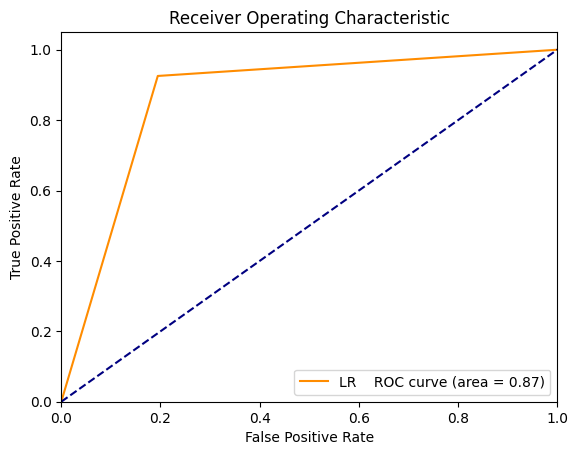

In [30]:
# Plotting the curves
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='LR    ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Testing the Model

In [17]:
test = pd.DataFrame({'Content': "you are an amazing person"}, index=[0])
test_pad = pad_sequences(tokenizer.texts_to_sequences(test.apply(preprocessing)), maxlen=max_seq_length)

score = model.predict(test_pad)[0][0]
if score < 0.45:
    print("NON-HATE")
else:
    print("HATE!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
NON-HATE


# GUI

## Run the following cell to launch a simple GUI to try the egybest model

In [2]:
import tkinter as tk
from tkinter import messagebox

# Create the main window
root = tk.Tk()
root.title("Text Analysis")

# Create a label and text entry field
label = tk.Label(root, text="Enter text:")
label.pack(pady=10)

text_entry = tk.Entry(root, width=50)
text_entry.pack(pady=5)

def analyze_text():
    text = text_entry.get()
    test = pd.DataFrame({'Content': text}, index=[0])
    test_preprocessed = test.apply(preprocessing)
    test_sequences = tokenizer.texts_to_sequences(test_preprocessed)
    test_pad = pad_sequences(test_sequences, maxlen=max_seq_length)
    
    score = model.predict(test_pad)[0][0]
    if score < 0.45:
        result = "NON-HATE"
    else:
        result = "HATE!"

    # Display the result in a message box
    messagebox.showinfo("Result", result)
    print (text)
    print (result)

# Create an Analyze button
analyze_button = tk.Button(root, text="Analyze", command=analyze_text)
analyze_button.pack(pady=20)

# Run the GUI event loop
root.mainloop()